## Multi-Cell NOMA

### Necessary Imports

In [1]:
import os
import sys

sys.path.append(os.path.abspath(".."))

import matplotlib.pyplot as plt
import numpy as np
import simcomm
import simcomm.metrics as metrics
import simcomm.utils as utils
from simcomm.fading import generate_channel
from simcomm.visualize import plot_network

plt.style.use("default")
plt.rcParams["figure.figsize"] = (6, 4)

### System Model

Parameters

In [14]:
# Multi-cell NOMA
N = 3  # Number of users
N_index = np.arange(N)  # Index of users
M = 2  # Number of BSs
M_index = np.arange(M)  # Index of BSs
T = 290  # Temperature in Kelvin
AREA = 500  # Area of the simulation m^2
ETA = 4  # path loss exponent
BANDWIDTH = 5e6  # bandwidth in Hz
NOISE = utils.get_noise(BANDWIDTH, T, 5)  # noise power in dBm
NOISE_LIN = utils.dbm2pow(NOISE)  # noise power in linear scale
S = 1000  # Number of monte carlo simulations

# Power parameters
Pt = np.linspace(-30, 30, 60)  # transmit power in dBm
Pt_lin = utils.dbm2pow(Pt)  # transmit power in linear scale
P_circuit = 1e-2  # circuit power in Watts

Creating Layout

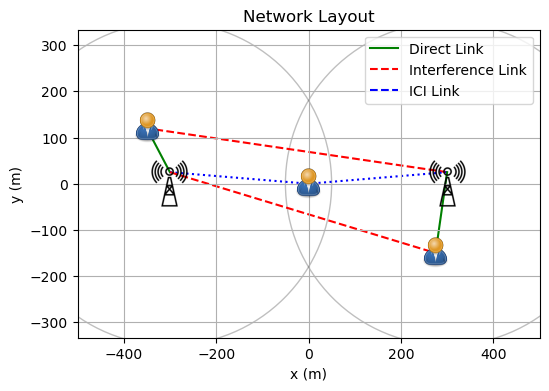

In [15]:
# Placing the base stations
bs_pos = np.array([[-300, 0, 30], [300, 0, 30]])
user_pos = np.array([[-350, 120, 0], [0, 0, 0], [275, -150, 0]])

# Plotting the network
plot_network(500, bs_pos, user_pos)

### Monte Carlo Simulations

In [ ]:
rate = np.zeros((S, N))
user_rate = np.zeros((S, N, len(Pt_lin)))
sum_rate = np.zeros(S, len(Pt_lin))
outage = np.zeros((S, N, len(Pt_lin)))
energy_eff = np.zeros((S, len(Pt_lin)))
spectral_eff = np.zeros((S, len(Pt_lin)))
r_min = 1

for mc in range(S):
    # Find distances between users and base stations
    distance_mat = np.zeros((M, N), dtype=np.float32)

    for m in range(M):
        for n in range(N):
            distance_mat[m, n] = utils.distance(bs_pos[m], user_pos[n], dim=3)

    # Compute the channel gains
    g = np.zeros((M, N), dtype=np.float32)

    for m in range(M):
        for n in range(N):
            g[m, n] = generate_channel("rayleigh", distance_mat[m, n], ETA)

    # Assigning alpha factors for fixed allocation
    alpha_c = 0.25  # alpha for cell-center users
    alpha_f = 0.75  # alpha for cell-edge users
    rate = np.zeros(N)
    user_rate = np.zeros((N, len(Pt_lin)))
    sum_rate = np.zeros(len(Pt_lin))
    outage = np.zeros((N, len(Pt_lin)))
    r_min = 0.5  # minimum rate requirement
    energy_eff = np.zeros(len(Pt_lin))
    spectral_eff = np.zeros(len(Pt_lin))

    for i in range(len(Pt_lin)):
        # Rate for user 1
        rate[0, :] = np.log2(
            1
            + Pt_lin[i]
            * alpha[0, 0]
            * g[0, 0, :]
            / (NOISE_LIN + Pt_lin[i] * alpha[0, 0] * g[0, 1, :])
        )

        # Rate for user 2 (interference link)
        rate[1, :] = np.log2(
            1
            + Pt_lin[i]
            * (alpha[0, 1] * g[1, 0, :] + alpha[1, 0] * g[1, 1, :])
            / (
                Pt_lin[i] * alpha[0, 0] * g[1, 0, :]
                + Pt_lin[i] * alpha[1, 1] * g[1, 1, :]
                + NOISE_LIN
            )
        )

        # Rate for user 3
        rate[2, :] = np.log2(
            1
            + Pt_lin[i]
            * alpha[1, 1]
            * g[2, 1, :]
            / (NOISE_LIN + Pt_lin[i] * alpha[1, 1] * g[2, 0, :])
        )

### Plots

In [ ]:
# User rates vs transmit power
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(Pt, user_rate[0, :], "g-", label="User 1")
plt.plot(Pt, user_rate[1, :], "r-", label="User 2 (ICI)")
plt.plot(Pt, user_rate[2, :], "m-", label="User 3")
plt.xlabel("Transmit Power (dBm)")
plt.ylabel("Rate (bps/Hz)")
plt.title("User Rates vs Transmit Power")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Sum rate vs transmit power
fig = plt.figure(figsize=(6, 4))
plt.plot(Pt, sum_rate, "b-", label="Sum Rate",
         linewidth=1, marker="o", markevery=5)
plt.xlabel("Transmit Power (dBm)")
plt.ylabel("Rate (bps/Hz)")
plt.title("Sum Rate vs Transmit Power")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Outage probability vs transmit power
fig, ax = plt.subplots(figsize=(6, 4))
plt.semilogy(Pt, outage[0, :], label="User 1",
             marker="o", linewidth=2, markevery=5)
plt.semilogy(
    Pt, outage[1, :], label="User 2 (ICI)", marker="o", linewidth=2, markevery=5
)
plt.semilogy(Pt, outage[2, :], label="User 3",
             marker="o", linewidth=2, markevery=5)
plt.xlabel("Transmit Power (dBm)")
plt.ylabel("Outage Probability")
plt.title("Outage Probability vs Transmit Power")
plt.xlim([-10, 20])
plt.ylim([1e-3, None])
plt.legend()
plt.grid(which="both")
plt.show()

In [ ]:
# SE-EE tradeoff
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(spectral_eff, energy_eff, "b-", linewidth=1)
plt.xlabel("Spectral Efficiency (bps/Hz)")
plt.ylabel("Energy Efficiency (bps/Joule)")
plt.title("SE-EE Tradeoff")
plt.grid()

# Find the peak point
peak_idx = np.argmax(energy_eff)
peak_x = spectral_eff[peak_idx]
peak_y = energy_eff[peak_idx]

# Add a marker at the peak point
plt.plot(peak_x, peak_y, marker="d", markersize=8, color="black")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.show()